# Calculating $\Sigma_{10}$


In the context of the paper "[The Sloan Lens ACS Survey. VIII. The Relation between Environment and Internal Structure of Early-Type Galaxies](https://arxiv.org/pdf/0806.1056.pdf)," the projected number density of galaxies inside the tenth nearest neighbor ($\Sigma_{10}$) refers to a measure of the local galaxy density surrounding a target early-type galaxy.

To explain this concept from the paper, we need to understand how the authors calculated $\Sigma_{10}$ and its significance in studying the relationship between galaxy environment and the internal structure of early-type galaxies.

1. Calculation of $\Sigma_{10}$:
In the paper, the authors studied a sample of early-type galaxies with measured gravitational lensing effects. For each target early-type galaxy, they identified its ten nearest neighbor galaxies based on their projected angular distances. The projected angular distance is the angular separation between the target galaxy and its neighbors as seen from our perspective on Earth.

$\Sigma_{10}$ is then calculated as the number of galaxies (including the target galaxy itself) within the combined area covered by the ten nearest neighbors, divided by the total area of that region. In other words, $\Sigma_{10}$ represents the number density of galaxies in the vicinity of the target galaxy, considering the influence of its ten closest neighbors.

2. Significance of $\Sigma_{10}$:
The projected number density $\Sigma_{10}$ is a crucial parameter to study the local galaxy environment around each early-type galaxy in the sample. It provides a measure of the galaxy density on small scales, capturing the immediate gravitational influences of nearby galaxies on the target galaxy.

By analyzing the correlation between $\Sigma_{10}$ and the internal properties of early-type galaxies (such as their effective radii and velocity dispersions), the authors can explore how the local galaxy environment affects the structure and evolution of early-type galaxies. High $\Sigma_{10}$ values imply dense environments with strong gravitational interactions, which might have implications for the growth and assembly history of the early-type galaxies.

In summary, $\Sigma_{10}$ quantifies the local galaxy density surrounding each target early-type galaxy in the sample. It plays a crucial role in understanding the impact of the immediate environment on the internal properties and evolution of these galaxies, providing insights into the complex interplay between galaxy environment and galaxy structure.

Finally calculations can be made by
$$\Sigma_{10} = 10/(\pi R_{10}^2)$$

## Issue for task

https://github.com/ajshajib/BDLensing/issues/191

We've to reproduce **figure no 4** of the SLACS paper for our paper.

In [ ]:
# import of standard python libraries

!pip install photutils
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.datasets import load_star_image
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Now back to calclating $R_{10}$

d -329.6820+02.9584 == DESIJ2158+0257 from https://www.astrouw.edu.pl/~jskowron/ra-dec/?q=d+-329.6820%2B02.9584

Final Deliverable: https://github.com/ajshajib/BDLensing/discussions/227

In [ ]:
from astropy.io import fits

# Load the FITS file
hdulist = fits.open('/content/drive/MyDrive/BDLensing/DESI-329.6820+02.9584_F140W_drz_sci.fits')
header = hdulist[0].header

# Extract pixel scale information
cdelt1 = header['CD1_1']  # Change this to the appropriate keyword if needed
cdelt2 = header['CD2_2']  # Change this to the appropriate keyword if needed

# Calculate image size in degrees
image_size_deg_x = abs(cdelt1) * data.shape[1]  # Assuming data is the loaded image
image_size_deg_y = abs(cdelt2) * data.shape[0]

print(f"Image size in X direction: {image_size_deg_x} degrees")
print(f"Image size in Y direction: {image_size_deg_y} degrees")


Image size in X direction: 0.0133333333333332 degrees
Image size in Y direction: 0.0111111111111111 degrees


In [ ]:
from astropy.io import fits

# Load the FITS file
hdulist = fits.open('/content/drive/MyDrive/BDLensing/DESI-329.6820+02.9584_F140W_drz_sci.fits')
header = hdulist[0].header

# Extract pixel scale information
cdelt1 = header.get('CD1_1', None)
cdelt2 = header.get('CD2_2', None)

# If CD1_1 and CD2_2 are not available, try CDELT1 and CDELT2
if cdelt1 is None:
    cdelt1 = header.get('CDELT1', None)
if cdelt2 is None:
    cdelt2 = header.get('CDELT2', None)

print(f"Pixel scale in X direction: {cdelt1} degrees per pixel")
print(f"Pixel scale in Y direction: {cdelt2} degrees per pixel")


Pixel scale in X direction: -2.2222222222222e-05 degrees per pixel
Pixel scale in Y direction: 2.22222222222222e-05 degrees per pixel


(2192, 2042)

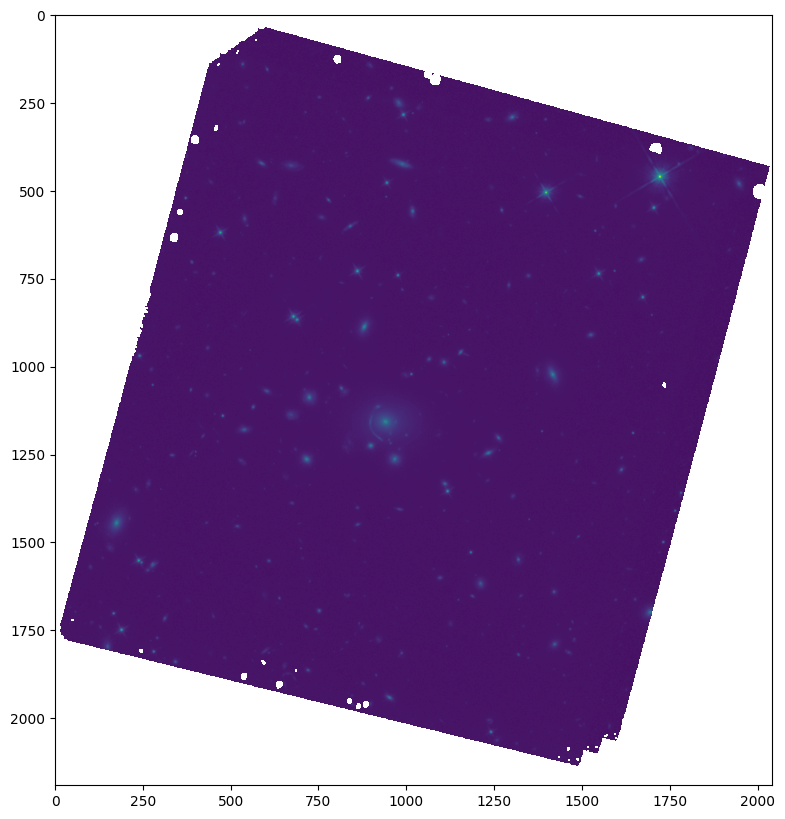

In [ ]:
gal = '/content/drive/MyDrive/BDLensing/DESI-329.6820+02.9584_F140W_drz_sci.fits'

fig, axis = plt.subplots(figsize=(10,10))
image_data = fits.getdata(gal, ext=0)
plt.imshow(np.log(image_data))
np.shape(image_data)

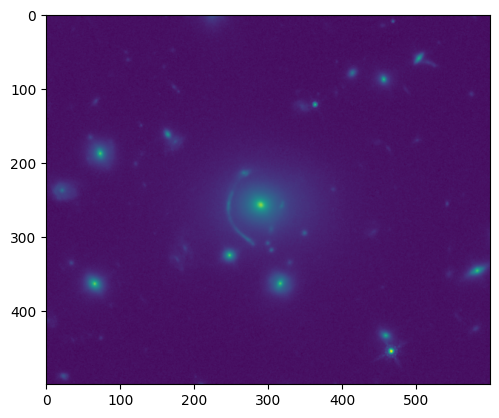

In [ ]:
data = image_data[900:1400, 650:1250]
plt.imshow(np.log(data))

Using Phototulis detection https://photutils.readthedocs.io/en/stable/detection.html

In [ ]:
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)

sources = daofind(data - median)

for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output

sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64
1,192.06,1.03,0.33,-0.92,-0.68,25,0.00,0.24,2.37,-0.94
2,577.21,1.64,0.38,0.71,-0.57,25,0.00,0.14,1.15,-0.15
3,161.75,2.09,0.35,0.37,0.38,25,0.00,0.12,1.37,-0.34
4,468.56,9.49,0.56,0.60,0.02,25,0.00,1.32,12.95,-2.78
5,530.41,38.02,0.35,0.20,-0.00,25,0.00,0.12,1.06,-0.06
6,107.57,50.88,0.57,0.07,-0.05,25,0.00,0.16,1.09,-0.09
7,503.50,59.18,0.45,-0.93,0.09,25,0.00,8.42,63.11,-4.50
8,110.33,61.18,0.34,-0.01,-0.02,25,0.00,0.21,1.36,-0.33
9,392.43,63.98,0.49,0.13,0.36,25,0.00,0.14,1.37,-0.34


A value of roundness close to zero usually indicates a more circular or round object, while values farther from zero suggest elongation or non-circular shapes.

In [ ]:
round_objects = abs(sources['roundness1']) > 0.70
sources.remove_rows(round_objects)
sources['id'] = list(range(len(sources)))

In [ ]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64
0,161.75,2.09,0.35,0.37,0.38,25,0.00,0.12,1.37,-0.34
1,468.56,9.49,0.56,0.60,0.02,25,0.00,1.32,12.95,-2.78
2,530.41,38.02,0.35,0.20,-0.00,25,0.00,0.12,1.06,-0.06
3,107.57,50.88,0.57,0.07,-0.05,25,0.00,0.16,1.09,-0.09
4,110.33,61.18,0.34,-0.01,-0.02,25,0.00,0.21,1.36,-0.33
5,392.43,63.98,0.49,0.13,0.36,25,0.00,0.14,1.37,-0.34
6,515.84,64.87,0.52,0.59,-0.66,25,0.00,0.41,1.98,-0.74
7,413.57,79.10,0.47,-0.34,0.23,25,0.00,2.32,12.65,-2.76
8,456.00,87.88,0.53,0.38,0.23,25,0.00,13.19,109.23,-5.10


(<matplotlib.patches.Circle at 0x7f7893461840>,)

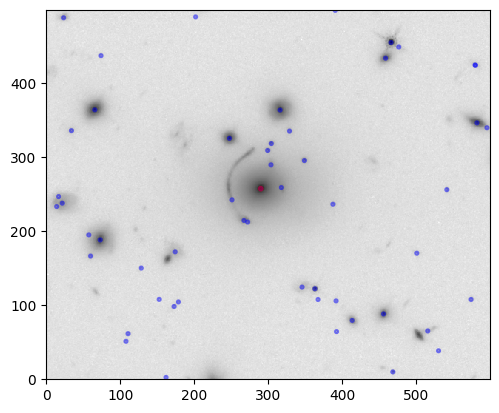

In [ ]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

apertures = CircularAperture(positions, r=2.0)
norm = ImageNormalize(stretch=SqrtStretch())

plt.imshow(np.log(data), cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

apertures.plot(color='blue', lw=1.5, alpha=0.5)

apertures[31].plot(color='red', lw=2, alpha=0.5)

In [ ]:
center_index = (sources['peak'] == sources['peak'].max()).nonzero()[0][0]
center = (sources[center_index][1],sources[center_index][2])
sources['dist'] = None
for i in sources:
    i['dist'] = np.sqrt( (i[1] - center[0])**2 + (i[2] - center[1])**2)

In [ ]:
sources.sort('dist')

In [ ]:
sources[:11]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,dist
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64,object
49,466.19,455.06,0.48,0.15,-0.02,25,0.00,104.06,1161.22,-7.66,0.0
48,476.54,449.02,0.52,-0.42,-0.54,25,0.00,0.38,2.37,-0.94,11.99279126661818
46,458.72,433.88,0.50,0.21,-0.19,25,0.00,9.85,75.89,-4.70,22.457265576283067
52,390.65,498.52,0.81,-0.05,-0.77,25,0.00,0.16,1.32,-0.30,87.14370590266823
45,579.73,424.72,0.29,-0.32,-0.14,25,0.00,0.31,1.39,-0.36,117.52746738028203
44,580.30,424.23,0.41,-0.70,-0.51,25,0.00,0.31,1.29,-0.27,118.20334548930013
41,582.36,346.39,0.53,-0.14,-0.13,25,0.00,17.36,110.05,-5.10,159.0795157429817
40,595.91,339.80,0.21,0.22,0.21,25,0.00,0.26,1.09,-0.09,173.53418202578223
43,316.06,363.69,0.56,-0.04,0.11,25,0.00,21.69,144.33,-5.40,175.74433742105538


In [77]:
R_10 = sources[10]['dist'] # In px ---> to be in deg
R_10

198.1110786995561

In [78]:
# Given pixel scale in degrees per pixel
angular_size_per_pixel = 2.22222222222222e-05  # degrees per pixel

# Convert pixels to radians
R_10_deg = R_10 * angular_size_per_pixel
R_10_deg

0.004402468415545686

In [79]:
Sigma_10=10/(np.pi * R_10_deg*2)
print(Sigma_10)

361.51296970104005
